<a href="https://www.kaggle.com/code/averma111/spaceship-titanic-wip?scriptVersionId=124740393" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

    
import warnings
warnings.filterwarnings('ignore')


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [4]:
ROOT_PATH = '/kaggle/input/spaceship-titanic/'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

## Reading Datasets

In [5]:
train_data = pd.read_csv(ROOT_PATH+TRAIN_FILE)
print(f'Number of rows = {train_data.shape[0]} and Number of cols ={train_data.shape[1]}')

Number of rows = 8693 and Number of cols =14


In [6]:
test_data = pd.read_csv(ROOT_PATH+TEST_FILE)
print(f'Number of rows = {test_data.shape[0]} and Number of cols ={test_data.shape[1]}')

Number of rows = 4277 and Number of cols =13


* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [7]:
train_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Summarizing the train datasets

In [8]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [9]:
summary(train_data)

,dtypes,null,unique,min,median,max,mean,std
PassengerId,object,0,8693,0001_01,463001.0,9280_02,inf,NaN
HomePlanet,object,201,3,NaN,NaN,NaN,NaN,NaN
CryoSleep,object,217,2,False,0.0,True,0.358306,0.479531
Cabin,object,199,6560,NaN,NaN,NaN,NaN,NaN
Destination,object,182,3,NaN,NaN,NaN,NaN,NaN
Age,float64,179,80,0.0,27.0,79.0,28.827930,14.489021
VIP,object,203,2,False,0.0,True,0.023439,0.151303
RoomService,float64,181,1273,0.0,0.0,14327.0,224.687617,666.717663
FoodCourt,float64,183,1507,0.0,0.0,29813.0,458.077203,1611.489240
ShoppingMall,float64,208,1115,0.0,0.0,23492.0,173.729169,604.696458


## Spliting the PassengerId columns and dropping orginal column


In [10]:
train_data['PassengerGGG'] = [x.split('_')[-0] for x in train_data['PassengerId']]
train_data['PassengerPP'] = [x.split('_')[-1] for x in train_data['PassengerId']]
train_data["PassengerGGG"] = train_data.PassengerGGG.astype(float)
train_data["PassengerPP"] = train_data.PassengerPP.astype(float)
train_data = train_data.drop('PassengerId',axis=1)

## Defining the columns types

In [11]:
NUMERICAL_COLS =['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age','PassengerGGG','PassengerPP']
CATEGORICAL_COLS =['HomePlanet','CryoSleep','Destination','VIP']
COLS_TO_DROP = ['Name','Cabin']

In [12]:
train_data = train_data.dropna(subset=CATEGORICAL_COLS)
train_data = train_data.dropna(subset=NUMERICAL_COLS)

In [13]:
summary(train_data)

,dtypes,null,unique,min,median,max,mean,std
HomePlanet,object,0,3,Earth,NaN,Mars,NaN,NaN
CryoSleep,object,0,2,False,0.0,True,0.353748,0.478167
Cabin,object,159,5413,NaN,NaN,NaN,NaN,NaN
Destination,object,0,3,55 Cancri e,NaN,TRAPPIST-1e,NaN,NaN
Age,float64,0,80,0.0,27.0,79.0,28.891665,14.514540
VIP,object,0,2,False,0.0,True,0.024411,0.154334
RoomService,float64,0,1128,0.0,0.0,14327.0,226.079590,673.908258
FoodCourt,float64,0,1346,0.0,0.0,29813.0,480.432760,1672.766209
ShoppingMall,float64,0,1008,0.0,0.0,23492.0,179.328037,633.614987
Spa,float64,0,1180,0.0,0.0,22408.0,318.185035,1159.247480


## Dropping columns not useful for prediction

In [14]:
train_data = train_data.drop(columns=COLS_TO_DROP)

## Categorial EDA

<Figure size 1200x1000 with 0 Axes>

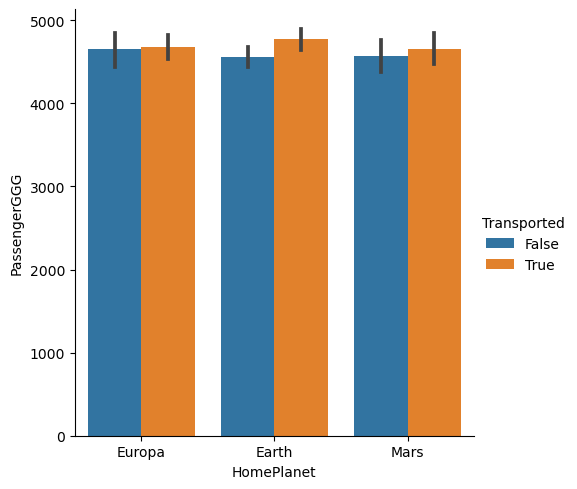

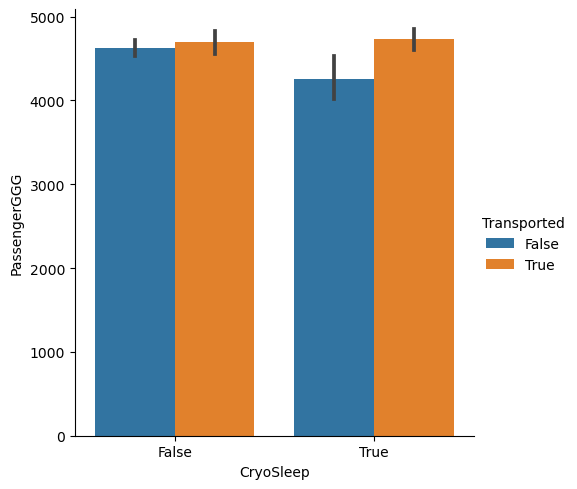

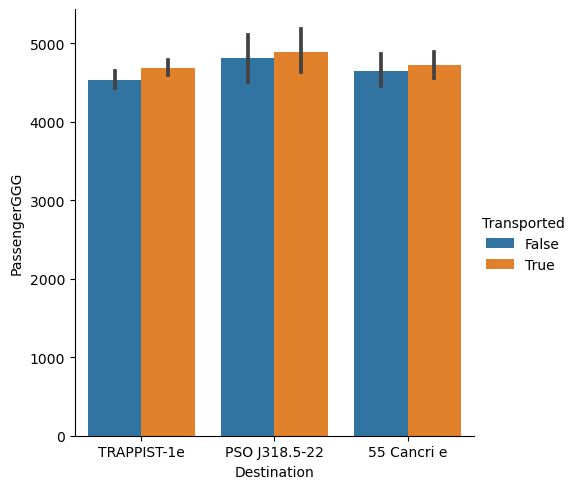

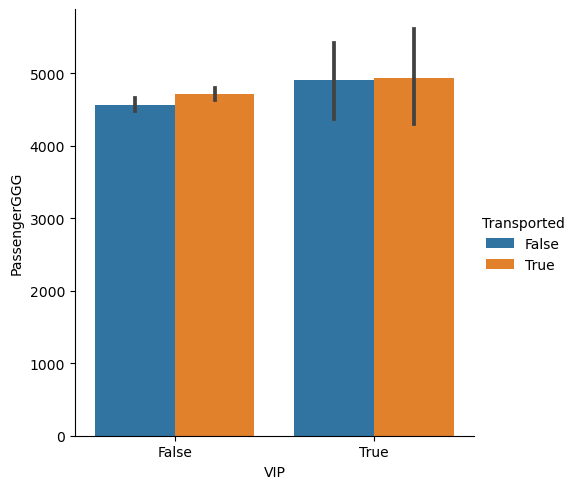

In [15]:
plt.figure(figsize=(12, 10))
for col in CATEGORICAL_COLS:
    if (train_data[col].dtype == np.object):
        sns.catplot(x=col,y='PassengerGGG' ,data=train_data,kind="bar",hue='Transported')
plt.show()   

## Continuous Columns EDA

In [16]:
plt.figure(figsize=(10,5))
for cols in NUMERICAL_COLS:
    if (train_data[col].dtype == np.float64):
        sns.relplot(data=train_data,x='PassengerGGG', y=cols, kind="line",hue="Transported") 
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:>

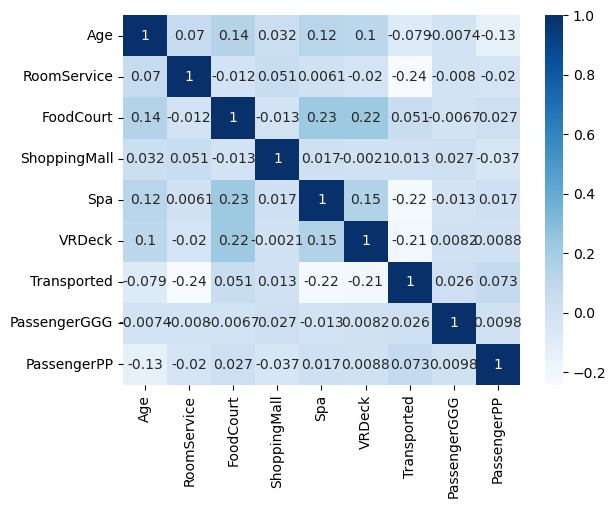

In [17]:
corr = train_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap="Blues", annot=True)

## Features Engineering

In [33]:
encoded_data = pd.get_dummies(CATEGORICAL_COLS)
for cols in encoded_data.columns:
    train_data[cols] = encoded_data[cols]

In [49]:
train_data.drop('Transported',axis=1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGGG,PassengerPP
0,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,1.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,2.0,1.0
2,0.0,0.0,1.0,58.0,0.0,43.0,3576.0,0.0,6715.0,49.0,3.0,1.0
3,0.0,0.0,0.0,33.0,1.0,0.0,1283.0,371.0,3329.0,193.0,3.0,2.0
4,NaN,NaN,NaN,16.0,NaN,303.0,70.0,151.0,565.0,2.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,NaN,NaN,NaN,41.0,NaN,0.0,6819.0,0.0,1643.0,74.0,9276.0,1.0
8689,NaN,NaN,NaN,18.0,NaN,0.0,0.0,0.0,0.0,0.0,9278.0,1.0
8690,NaN,NaN,NaN,26.0,NaN,0.0,0.0,1872.0,1.0,0.0,9279.0,1.0
8691,NaN,NaN,NaN,32.0,NaN,0.0,1049.0,0.0,353.0,3235.0,9280.0,1.0


In [50]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(train_data)

In [51]:
X = data_with_imputed_values
y = train_data['Transported']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=52)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5538, 13)
(1385, 13)
(5538,)
(1385,)


In [63]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
LR.predict(X_test)
score = LR.score(X_test, y_test)
print(score)

0.9494584837545126
